In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append("../../")

In [3]:
import eventx
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
import io

from pathlib import Path
from typing import List
from itertools import chain, accumulate

from eventx.predictors.predictor_utils import load_predictor
from eventx.models.model_utils import batched_predict_json
from eventx.predictors import snorkel_predictor, smartdata_predictor
from eventx.util import scorer
from eventx.util import utils
from eventx.util import evaluate
from eventx import SD4M_RELATION_TYPES, ROLE_LABELS

from allennlp.predictors import Predictor

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rcParams["font.family"] = "Palatino"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
CUDA_DEVICE = -1  # or -1 if no GPU is available

In [5]:
# Change paths
DATASET_PATH = "../../data/daystream_corpus/test/test_sd4m_with_events.jsonl"
PREDICTOR_NAME = "snorkel-eventx-predictor"
# PREDICTOR_NAME = "smartdata-eventx-predictor"

## Load the test data, models and do predictions

Filter documents that do not contain any entity of type trigger as they are not relevant for the event extraction task.

In [6]:
test_docs = evaluate.load_test_data(DATASET_PATH)

In [7]:
model_base_path = Path("../../data/runs/")
model_names = [
    "snorkel_bert_gold",
    "snorkel_bert_daystream",
    "snorkel_bert_merged"
]

In [8]:
predicted_docs = {}
for model_name in model_names:
    predictor = load_predictor(model_base_path.joinpath(model_name), PREDICTOR_NAME, CUDA_DEVICE)
    predicted_docs[model_name] = batched_predict_json(predictor=predictor, examples=test_docs)

## Conventional evaluation using sklearn toolkit
We simply consider the trigger & role label sequences disregarding the correctness of the corresponding trigger label when evaluating the argument roles to use the sklearn toolkit.

In [9]:
trigger_y_pred, arg_y_pred = {}, {}
for model_name in model_names:
    label_arrays = evaluate.get_label_arrays(test_docs, predicted_docs[model_name])
    trigger_y_true, trigger_y_pred[model_name] = label_arrays["trigger_y_true"], label_arrays["trigger_y_pred"]
    arg_y_true, arg_y_pred[model_name] = label_arrays["arg_y_true"], label_arrays["arg_y_pred"]

### Trigger classification

#### Model trained with SD4M gold training data

In [10]:
print(sklearn.metrics.classification_report(trigger_y_true, trigger_y_pred["snorkel_bert_gold"], SD4M_RELATION_TYPES[:-1]))

                        precision    recall  f1-score   support

              Accident       0.75      0.67      0.71         9
         CanceledRoute       1.00      0.80      0.89        10
          CanceledStop       1.00      1.00      1.00         3
                 Delay       1.00      1.00      1.00         2
           Obstruction       0.92      1.00      0.96        12
RailReplacementService       1.00      0.80      0.89         5
            TrafficJam       0.88      0.88      0.88        16

             micro avg       0.91      0.86      0.88        57
             macro avg       0.94      0.88      0.90        57
          weighted avg       0.91      0.86      0.88        57



#### Model trained with probabilistically labeled Daystream data (using Snorkel)

In [11]:
print(sklearn.metrics.classification_report(trigger_y_true, trigger_y_pred["snorkel_bert_daystream"], SD4M_RELATION_TYPES[:-1]))

                        precision    recall  f1-score   support

              Accident       0.89      0.89      0.89         9
         CanceledRoute       1.00      0.70      0.82        10
          CanceledStop       1.00      1.00      1.00         3
                 Delay       1.00      1.00      1.00         2
           Obstruction       0.85      0.92      0.88        12
RailReplacementService       1.00      0.60      0.75         5
            TrafficJam       0.87      0.81      0.84        16

             micro avg       0.90      0.82      0.86        57
             macro avg       0.94      0.85      0.88        57
          weighted avg       0.91      0.82      0.86        57



#### Model trained with SD4M gold training data augmented with probabilistically labeled Daystream data (Snorkel)

In [12]:
print(sklearn.metrics.classification_report(trigger_y_true, trigger_y_pred["snorkel_bert_merged"], SD4M_RELATION_TYPES[:-1]))

                        precision    recall  f1-score   support

              Accident       0.80      0.89      0.84         9
         CanceledRoute       1.00      0.80      0.89        10
          CanceledStop       1.00      1.00      1.00         3
                 Delay       1.00      1.00      1.00         2
           Obstruction       0.80      1.00      0.89        12
RailReplacementService       1.00      0.80      0.89         5
            TrafficJam       0.88      0.88      0.88        16

             micro avg       0.88      0.89      0.89        57
             macro avg       0.92      0.91      0.91        57
          weighted avg       0.89      0.89      0.89        57



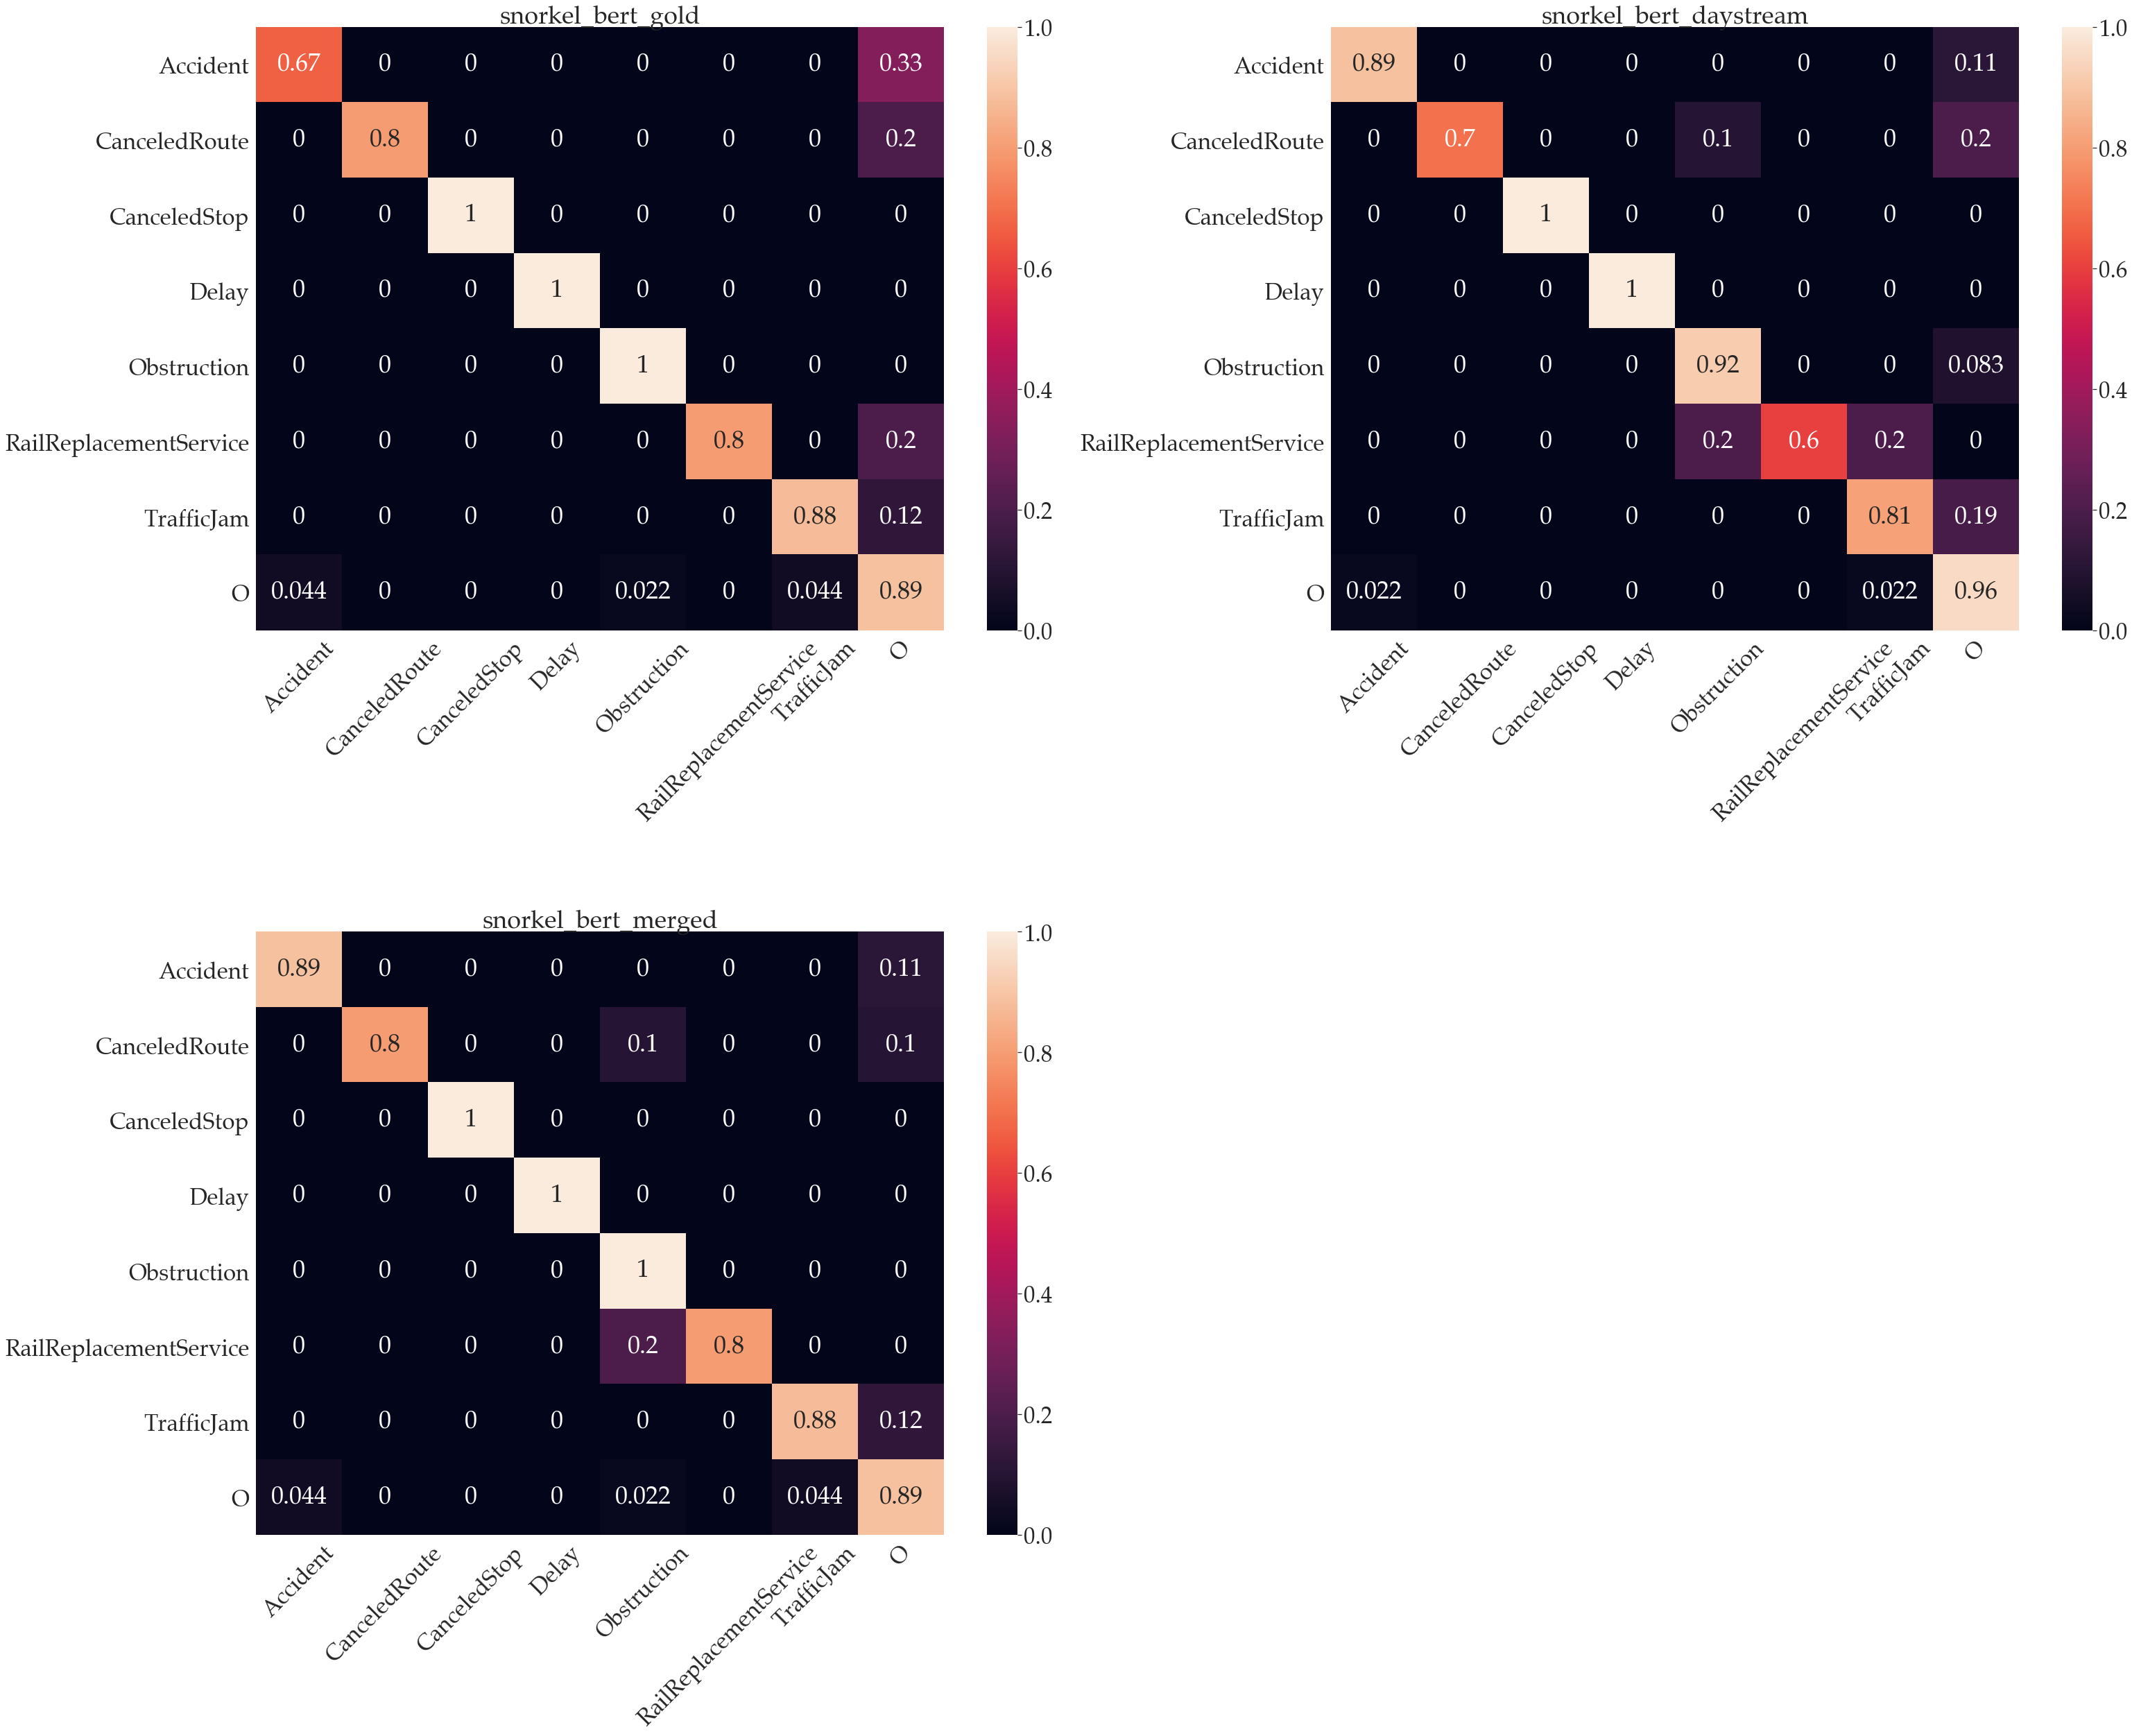

In [13]:
sns.set(font_scale=3, font="Palatino")
f, axes = plt.subplots(2, 2, figsize=(50,40))
f.suptitle('Normalized Confusion Matrices - Trigger classification')
flat_axes = axes.flatten()
for i, model_name in enumerate(model_names):
    cm = sklearn.metrics.confusion_matrix(trigger_y_true, trigger_y_pred[model_name], labels=SD4M_RELATION_TYPES)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = SD4M_RELATION_TYPES, columns = SD4M_RELATION_TYPES).round(3)
    g = sns.heatmap(df_cm, ax=flat_axes[i], annot=True)
    flat_axes[i].set_title(model_name)
    g.set_xticklabels(g.get_xticklabels(), rotation = 45)
    plt.subplots_adjust(wspace=.25, hspace=.5)
f.delaxes(axes[1,1])

### Argument role classification

#### Model trained with SD4M gold training data

In [14]:
print(sklearn.metrics.classification_report(arg_y_true, arg_y_pred["snorkel_bert_gold"], ROLE_LABELS[:-1]))

              precision    recall  f1-score   support

    location       0.83      0.63      0.72        84
       delay       1.00      0.88      0.93         8
   direction       0.88      0.68      0.76        31
   start_loc       0.82      0.79      0.81        39
     end_loc       0.69      0.82      0.75        38
  start_date       1.00      0.22      0.36         9
    end_date       0.50      0.50      0.50         2
       cause       0.71      0.80      0.75        15
  jam_length       1.00      1.00      1.00        13
       route       0.75      1.00      0.86         3

   micro avg       0.81      0.72      0.76       242
   macro avg       0.82      0.73      0.74       242
weighted avg       0.82      0.72      0.75       242



#### Model trained with probabilistically labeled Daystream data (using Snorkel)

In [15]:
print(sklearn.metrics.classification_report(arg_y_true, arg_y_pred["snorkel_bert_daystream"], ROLE_LABELS[:-1]))

              precision    recall  f1-score   support

    location       0.80      0.48      0.60        84
       delay       0.00      0.00      0.00         8
   direction       0.83      0.77      0.80        31
   start_loc       0.80      0.82      0.81        39
     end_loc       0.88      0.74      0.80        38
  start_date       0.70      0.78      0.74         9
    end_date       1.00      1.00      1.00         2
       cause       1.00      0.73      0.85        15
  jam_length       0.93      1.00      0.96        13
       route       1.00      0.33      0.50         3

   micro avg       0.84      0.65      0.73       242
   macro avg       0.79      0.67      0.71       242
weighted avg       0.81      0.65      0.71       242



/Users/phuc/opt/miniconda3/envs/eventx/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Model trained with SD4M gold training data augmented with probabilistically labeled Daystream data (Snorkel)

In [16]:
print(sklearn.metrics.classification_report(arg_y_true, arg_y_pred["snorkel_bert_merged"], ROLE_LABELS[:-1]))

              precision    recall  f1-score   support

    location       0.85      0.68      0.75        84
       delay       0.89      1.00      0.94         8
   direction       0.88      0.74      0.81        31
   start_loc       0.79      0.87      0.83        39
     end_loc       0.76      0.84      0.80        38
  start_date       1.00      0.33      0.50         9
    end_date       1.00      0.50      0.67         2
       cause       0.67      0.80      0.73        15
  jam_length       0.93      1.00      0.96        13
       route       0.75      1.00      0.86         3

   micro avg       0.82      0.77      0.79       242
   macro avg       0.85      0.78      0.78       242
weighted avg       0.83      0.77      0.79       242



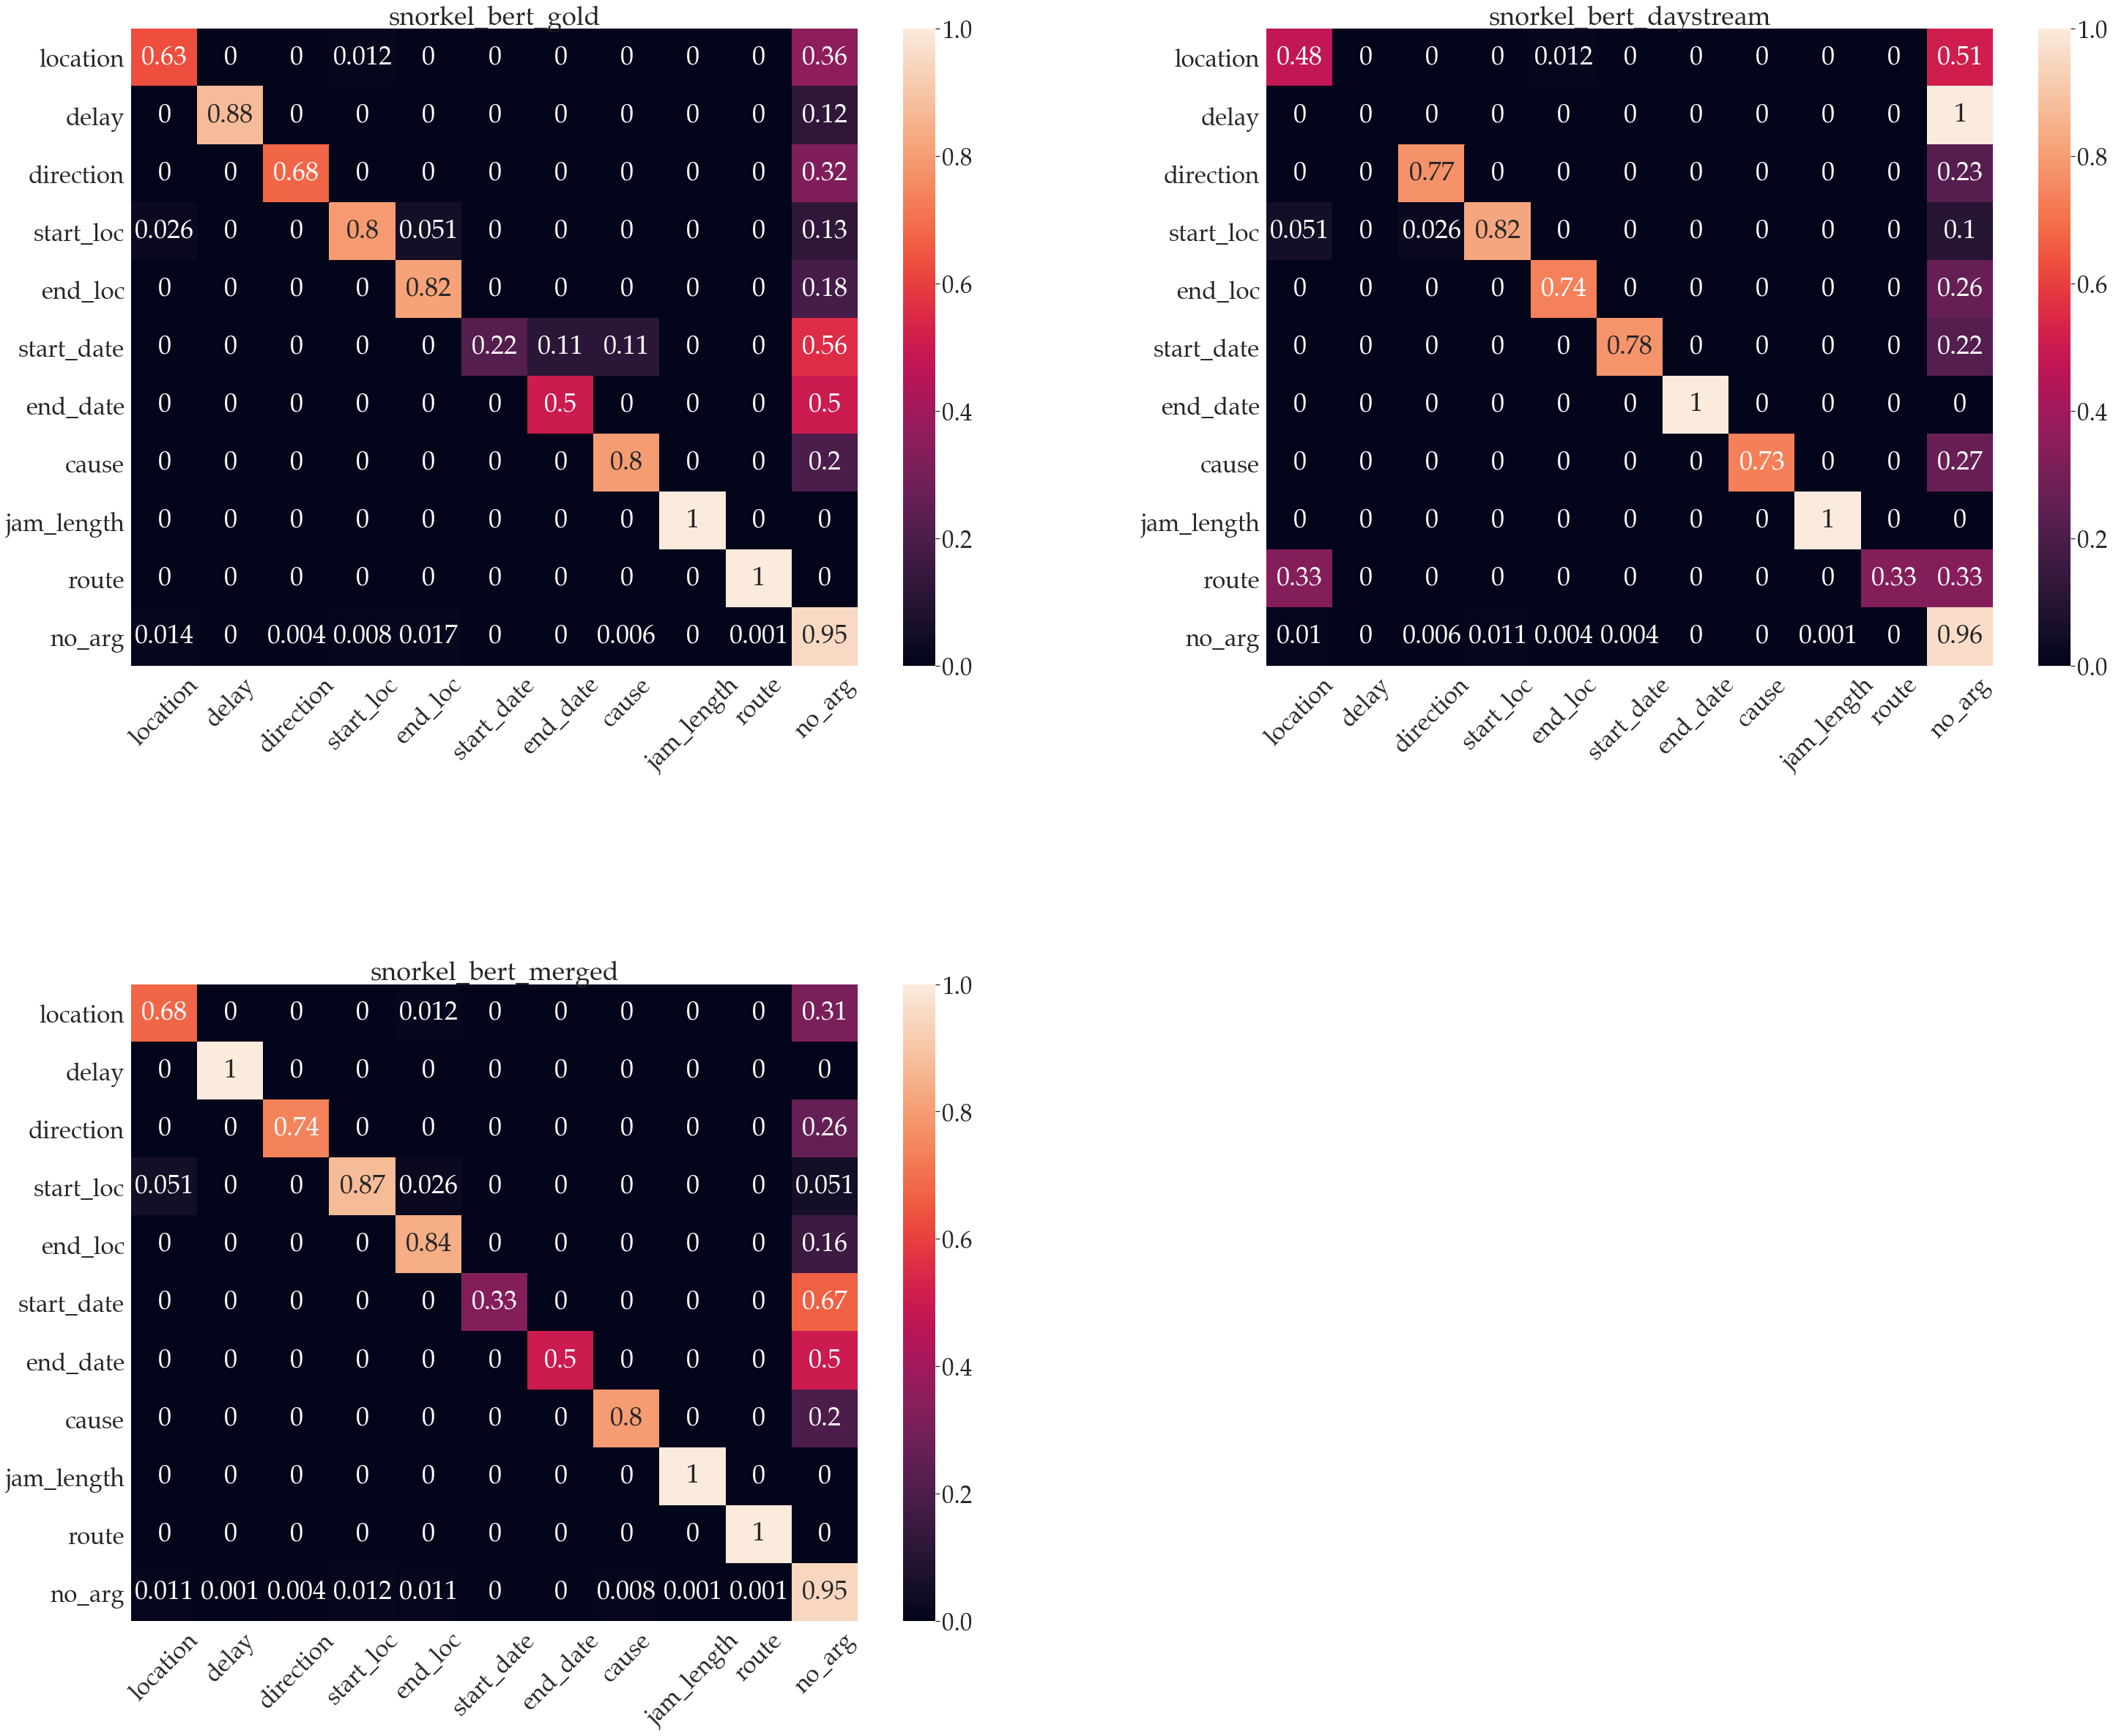

In [17]:
sns.set(font_scale=3, font="Palatino")
f, axes = plt.subplots(2, 2, figsize=(50,40))
f.suptitle('Normalized Confusion Matrices - Argument classification')
flat_axes = axes.flatten()
for i, model_name in enumerate(model_names):
    cm = sklearn.metrics.confusion_matrix(arg_y_true, arg_y_pred[model_name], labels=ROLE_LABELS)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=ROLE_LABELS, columns=ROLE_LABELS).round(3)
    g = sns.heatmap(df_cm, ax=flat_axes[i], annot=True)
    flat_axes[i].set_title(model_name)
    g.set_xticklabels(g.get_xticklabels(), rotation = 45)
    plt.subplots_adjust(wspace=.25, hspace=.5)
f.delaxes(axes[1,1])

## Examining the predictions

The original corpus was annotated with n-ary relations, which we converted to events. A relation was only annotated if all the required arguments (for mobility events usually `trigger` and `location`) were in the same sentence. The annotators were asked to determine whether they were in the same sentence based on the syntax and punctuation, i.e. they were presented with the full document text during the annotation process and had to mentally draw the sentence boundaries.
While examining the corpus we found the quality of the automatic sentence splitting with stanfordnlp insufficient as it struggled with the many abbreviations, dates, hashtags that are prevalent in the corpus texts. 
We observed 92 instances in the SD4M training split, where the trigger and the argument ended up in different sentences according to the stanfordnlp sentence splitter and would have been lost if we fed the model the sentences instead of documents.
That is why we chose to feed entire documents into the model as opposed to feeding it single sentences.

Due to the nature of the annotation (sentence level n-ary relations converted to events) and the input format (document level) it could be that the model predicts correct document level positive argument roles - where trigger and argument are not in the same sentence - that are not annotated in the gold data.
There is also the possibility of false positives for event triggers that are not actually false positives, i.e. event triggers that were not annotated as such because a required argument (`location`) was missing. According to the annotation guidelines this should not happen as the annotators were asked to only annotate `trigger` entities as such only if a relation is expressed in the sentence, i.e. the potential event trigger was most likely not even annotated as a `trigger` entity and is not recognized as a potential event trigger by the eventx model.
We manually examine the predictions and look for such instances.

There were 68 documents in the test set, of which 23 contained multiple sentences and 45 consisted of a single sentence.
We observed that the model trained on the gold SD4M training data predicted 16 wrong arguments that were not in the same sentence as the trigger, but found one instance, where the model predicted a correct location argument in a preceding sentence for a `TrafficJam` trigger. That `TrafficJam` event was not annotated in the gold data as the required `location` argument was not in the same sentence as the trigger. According to the annotation guidelines that trigger should not have been annotated as a trigger entity.

> Die **A46**\[`location`\] Düsseldorf / Wuppertal ist zwischen Düsseldorf-Holthausen und Düsseldorf-Bilk in beiden Richtungen wegen Überflutung gesperrt. Zurzeit 2 km **Stau**\[`TrafficJam`\] in Richtung Düsseldorf. Der Universitätstunnel und der Tunnel Wersten stehen unter Wasser.\n

The model that was trained on the probabilistically labeled Daystream data and the model that was trained on the combined training set predicted a correct `jam_length` argument for that same `TrafficJam` event, which was counted as a false positive because the event was not annotated in the gold data due to the required `location` argument not being in the same sentence.

> Die A46 Düsseldorf / Wuppertal ist zwischen Düsseldorf-Holthausen und Düsseldorf-Bilk in beiden Richtungen wegen Überflutung gesperrt. Zurzeit **2 km**\[`jam_length` \] **Stau**\[`TrafficJam`\] in Richtung Düsseldorf. Der Universitätstunnel und der Tunnel Wersten stehen unter Wasser.\n

For the model that was trained on the probabilistically labeled Daystream data, we observed 4 instances, where the model predicted wrong arguments that were not in the same sentence as the trigger. We found 2 instances, where the model predicted correct date arguments that were in the preceding sentence of the trigger.

> folgende Meldung korrigiert\nvon **Mittwoch, 23. März**\[`start_date`\], 22.10 Uhr bis Dienstag, 29. März, 7.45 Uhr\nMeldung:\nDie EC-Züge werden zwischen Berlin Hbf und Frankfurt (Oder) durch **Busse ersetzt**\[`RailReplacementService`\]. \[...\]

> am **Dienstag, 2. August**\[`start_date`\], 3.00 – 3.45 Uhr\nMeldung:\nIC 2020 nach Hamburg-Altona (23.24 Uhr ab Frankfurt (Main) Hbf) wird von Essen Hbf bis Dortmund Hbf **umgeleitet**\[`Obstruction`\] und hält nicht in Bochum Hbf.

For the model that was trained on the combined training set, we found 3 instances, where it predicted wrong arguments that were not in the same sentence as the trigger.

## Event extraction evaluation using correctness criteria defined by Ji, Heng and Grishman, Ralph 2008

Ji, Heng and Grishman, Ralph (2008). Refining event extraction through cross-document inference.
> - A trigger is correctly labeled if its event type and offsets match a reference trigger.
> - An argument is correctly identified if its event type and offsets match any of the reference argument mentions.
> - An argument is correctly identified and classified if its event type, offsets, and role match any of the reference argument mentions.

The main difference to the previous evaluation method lies in the correctness criteria for the arguments. Here we additionally consider the correctness of the event type for the argument.

Caution:
Using the following methods to retrieve the triggers and arguments from the gold data might result in duplicate gold triggers & arguments.
This is due to different events possibly sharing the same trigger.
The model is not able to distinguish such events and instead fuses them all together, which results in lower recall.
If we remove duplicates from the gold triggers and gold arguments, recall and consequently f1 should be higher.

In [18]:
REMOVE_DUPLICATES = True  # change to False if you want to keep duplicate triggers/ arguments from the gold data caused by events sharing the same trigger

In [19]:
gold_triggers = scorer.get_triggers(test_docs)
gold_arguments = scorer.get_arguments(test_docs)

In [20]:
if REMOVE_DUPLICATES:
    gold_triggers = list(set(gold_triggers))
    gold_arguments = list(set(gold_arguments))

In [21]:
pred_triggers = {}
pred_arguments = {}
for model_name in model_names:
    pred_triggers[model_name] = scorer.get_triggers(predicted_docs[model_name])
    pred_arguments[model_name] = scorer.get_arguments(predicted_docs[model_name])

In [22]:
for model_name in model_names:
    print(model_name)
    trigger_id_metrics = scorer.get_trigger_identification_metrics(gold_triggers, pred_triggers[model_name], output_string=True)
    print('\n')

snorkel_bert_gold
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Trigger identification              0.91      0.86      0.88        57


snorkel_bert_daystream
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Trigger identification              0.96      0.88      0.92        57


snorkel_bert_merged
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Trigger identification              0.91      0.93      0.92        57




In [23]:
for model_name in model_names:
    print(model_name)
    trigger_class_metrics = scorer.get_trigger_classification_metrics(gold_triggers, pred_triggers[model_name], output_string=True)
    print('\n')

snorkel_bert_gold
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Trigger classification              0.91      0.86      0.88        57
Accident                            0.75      0.67      0.71         9
CanceledRoute                       1.00      0.80      0.89        10
CanceledStop                        1.00      1.00      1.00         3
Delay                               1.00      1.00      1.00         2
Obstruction                         0.92      1.00      0.96        12
RailReplacementService              1.00      0.80      0.89         5
TrafficJam                          0.88      0.88      0.88        16


snorkel_bert_daystream
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
----

In [24]:
for model_name in model_names:
    print(model_name)
    argument_id_metrics = scorer.get_argument_identification_metrics(gold_arguments, pred_arguments[model_name], output_string=True)
    print('\n')

snorkel_bert_gold
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Argument identification             0.83      0.74      0.78       244


snorkel_bert_daystream
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Argument identification             0.83      0.64      0.72       244


snorkel_bert_merged
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Argument identification             0.82      0.77      0.79       244




In [25]:
for model_name in model_names:
    print(model_name)
    argument_class_metrics = scorer.get_argument_classification_metrics(gold_arguments, pred_arguments[model_name], output_string=True)
    print('\n')

snorkel_bert_gold
--------------------------------------------------------------------------------
                               precision    recall  f1-score   support
--------------------------------------------------------------------------------
Argument classification             0.81      0.71      0.76       244
location                            0.83      0.63      0.72        84
delay                               1.00      0.88      0.93         8
direction                           0.88      0.68      0.76        31
start_loc                           0.82      0.79      0.81        39
end_loc                             0.69      0.79      0.74        39
start_date                          1.00      0.22      0.36         9
end_date                            0.50      0.33      0.40         3
cause                               0.71      0.80      0.75        15
jam_length                          1.00      1.00      1.00        13
route                               0.7

### 5 Repeated Runs
5 repeated runs for each configuration with random seeds for the snorkel label models and eventx model.
Metrics are given as mean & standard deviation.

In [26]:
model_base_path = Path("../../data/runs/random_repeats")
runs = 5
trigger_metrics_rr, argument_metrics_rr = {}, {}
for model_name in model_names:
    print(model_name)
    model_paths = [model_base_path.joinpath(f'run_{run+1}/{model_name}') for run in range(runs)]
    trigger_metrics_rr[model_name], argument_metrics_rr[model_name] = evaluate.summize_multiple_runs(model_paths, test_docs)
    formatted_trigger = evaluate.format_classification_report(evaluate.get_mean_std(trigger_metrics_rr[model_name]), make_string=True)
    formatted_argument = evaluate.format_classification_report(evaluate.get_mean_std(argument_metrics_rr[model_name]), make_string=True)
    formatted_metrics = pd.concat([formatted_trigger, formatted_argument])
    formatted_metrics.set_index('row_name', inplace=True)
    display(formatted_metrics.loc[['Trigger identification', 'Trigger classification', 'Argument identification', 'Argument classification']])
    print('\n')

snorkel_bert_gold


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,92.0+/- 0.7,88.4+/- 1.4,90.2+/- 0.6,57
Trigger classification,90.5+/- 1.7,87.0+/- 1.8,88.7+/- 1.5,57
Argument identification,80.7+/- 1.8,75.4+/- 3.4,77.9+/- 1.8,244
Argument classification,78.2+/- 1.8,73.1+/- 3.2,75.5+/- 1.8,244




snorkel_bert_daystream


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,92.3+/- 2.6,83.9+/- 3.0,87.9+/- 2.3,57
Trigger classification,87.7+/- 2.4,79.6+/- 3.3,83.4+/- 2.5,57
Argument identification,82.6+/- 3.5,62.1+/- 4.6,70.8+/- 2.9,244
Argument classification,78.9+/- 4.9,59.2+/- 3.5,67.5+/- 2.6,244




snorkel_bert_merged


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,92.6+/- 0.7,91.9+/- 1.8,92.2+/- 1.1,57
Trigger classification,88.7+/- 2.3,88.1+/- 2.0,88.4+/- 2.0,57
Argument identification,85.3+/- 3.1,79.2+/- 2.1,82.1+/- 2.4,244
Argument classification,83.4+/- 3.3,77.4+/- 2.2,80.3+/- 2.5,244


### Does increasing the amount of snorkel labeled training data improve model performance?
Compare model performance with increasing amount of snorkel labeled data.
We sample 50%, 60%, ..., 100% from the Daystream data. We do this 6 times with different random states and look at the macro averaged f1-score to reduce the effects (un)lucky samples during the sampling process.
We encountered OOV errors for the models that were trained with less of the training data. We omit the test scores of these models and report how many scores were used per sample size to calculate the mean & standard deviation.

Sample sizes and how many test scores:
- 50%: sample runs 3, 4, 6
- 60%: sample runs 1, 4-6 
- 70%: sample runs 2-6
- 80%: sample runs 1, 3-6
- 90%: sample runs 1-6
- 100%: whole Daystream train data

In [27]:
# increasing training data over 5 different sample runs: getting a bunch of entity_tags vocabulary key errors (removed from evaluation)
model_names = [f'daystream{percentage}_snorkeled' for percentage in range(50,101,10)]
model_base_path = Path("../../data/runs/increasing_train_data")
runs = 6
trigger_metrics, argument_metrics = {}, {}
for model_name in model_names:
    print(model_name)
    model_paths = [model_base_path.joinpath(f'samples_{run+1}/{model_name}') for run in range(runs)]
    trigger_metrics[model_name], argument_metrics[model_name] = evaluate.summize_multiple_runs(model_paths, test_docs)

daystream50_snorkeled


ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-27 19:52:25,592 - The model ../../data/runs/increasing_train_data/samples_1/daystream50_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.
ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-27 19:52:32,709 - The model ../../data/runs/increasing_train_data/samples_2/daystream50_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.
ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-27 19:53:27,023 - The model ../../data/runs/increasing_train_data/samples_5/daystream50_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.


daystream60_snorkeled


ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-27 19:54:14,445 - The model ../../data/runs/increasing_train_data/samples_2/daystream60_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.
ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-27 19:54:25,490 - The model ../../data/runs/increasing_train_data/samples_3/daystream60_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.


daystream70_snorkeled


ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-27 19:55:35,151 - The model ../../data/runs/increasing_train_data/samples_1/daystream70_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.


daystream80_snorkeled


ERROR:allennlp.data.vocabulary:Namespace: entity_tags
ERROR:allennlp.data.vocabulary:Token: I-NUMBER
2020-07-27 19:57:58,621 - The model ../../data/runs/increasing_train_data/samples_2/daystream80_snorkeled encountered an OOV error ('@@UNKNOWN@@'). Skip and continue.


daystream90_snorkeled
daystream100_snorkeled


In [52]:
def get_infos(metrics, metric_name, labels=None):
    table = []
    for idx, (k,v) in enumerate(metrics.items()):
        if labels is None:
            tmp = {'Model': k}
        else:
            tmp = {'Sample size in %': labels[idx]}
        tmp[metric_name] = np.median(v[metric_name]['f1-score'])*100  # turn into percentage
        table.append(tmp)
    if labels is None:
        return pd.DataFrame(table).set_index('Model')
    else:
        return pd.DataFrame(table).set_index('Sample size in %')

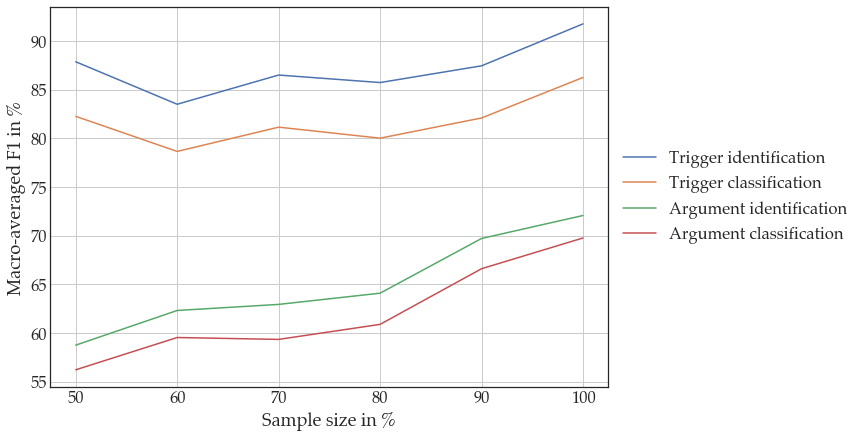

In [55]:
sns.set(font_scale=1.5, font="Palatino")
sample_sizes = [percentage for percentage in range(50,101,10)]
progression_table = get_infos(trigger_metrics, 'Trigger identification', labels=sample_sizes)
progression_table = progression_table.merge(get_infos(trigger_metrics, 'Trigger classification', labels=sample_sizes), left_index=True, right_index=True)
progression_table = progression_table.merge(get_infos(argument_metrics, 'Argument identification', labels=sample_sizes), left_index=True, right_index=True)
progression_table = progression_table.merge(get_infos(argument_metrics, 'Argument classification', labels=sample_sizes), left_index=True, right_index=True)
with plt.style.context("seaborn-white"):
    plt.rcParams["font.family"] = "Palatino"
    fig, ax = plt.subplots(figsize=(10,7))
    ax.set_ylabel('Macro-averaged F1 in %')
    progression_table.plot(ax=ax, grid=True)
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

In [30]:
for model_name in model_names:
    print(model_name)
    formatted_trigger = evaluate.format_classification_report(evaluate.get_mean_std(trigger_metrics[model_name]), make_string=True)
    formatted_argument = evaluate.format_classification_report(evaluate.get_mean_std(argument_metrics[model_name]), make_string=True)
    formatted_metrics = pd.concat([formatted_trigger, formatted_argument])
    formatted_metrics.set_index('row_name', inplace=True)
    display(formatted_metrics.loc[['Trigger identification', 'Trigger classification', 'Argument identification', 'Argument classification']])
    print('\n')

daystream50_snorkeled


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,91.3+/- 2.0,84.8+/- 2.2,87.9+/- 0.5,57
Trigger classification,84.9+/- 2.9,78.9+/- 3.8,81.8+/- 2.8,57
Argument identification,73.3+/- 3.3,48.4+/- 4.4,58.2+/- 3.8,244
Argument classification,68.3+/- 5.3,45.1+/- 5.2,54.2+/- 5.1,244




daystream60_snorkeled


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,92.4+/- 1.2,75.0+/- 4.5,82.7+/- 3.0,57
Trigger classification,86.5+/- 1.9,70.2+/- 4.5,77.4+/- 3.2,57
Argument identification,80.6+/- 3.2,51.2+/- 3.1,62.6+/- 2.5,244
Argument classification,76.2+/- 5.0,48.4+/- 3.5,59.1+/- 3.5,244




daystream70_snorkeled


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,90.2+/- 1.8,80.7+/- 4.0,85.1+/- 2.7,57
Trigger classification,84.3+/- 2.9,75.4+/- 4.6,79.6+/- 3.6,57
Argument identification,77.2+/- 4.6,54.9+/- 3.9,64.1+/- 3.5,244
Argument classification,72.6+/- 6.2,51.7+/- 5.5,60.3+/- 5.4,244




daystream80_snorkeled


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,90.8+/- 2.6,80.4+/- 5.7,85.2+/- 4.0,57
Trigger classification,83.2+/- 4.7,73.7+/- 6.7,78.1+/- 5.6,57
Argument identification,74.7+/- 4.1,56.6+/- 1.5,64.4+/- 1.4,244
Argument classification,70.7+/- 4.2,53.6+/- 1.2,60.9+/- 1.4,244




daystream90_snorkeled


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,93.1+/- 2.8,82.5+/- 3.8,87.4+/- 3.1,57
Trigger classification,87.1+/- 2.6,77.2+/- 3.5,81.8+/- 2.9,57
Argument identification,80.8+/- 2.2,61.1+/- 2.1,69.6+/- 2.0,244
Argument classification,77.5+/- 2.2,58.5+/- 2.2,66.7+/- 2.2,244




daystream100_snorkeled


,precision,recall,f1-score,support
row_name,,,,
Trigger identification,96.2+/- 0.0,87.7+/- 0.0,91.7+/- 0.0,57
Trigger classification,90.4+/- 0.0,82.5+/- 0.0,86.2+/- 0.0,57
Argument identification,82.5+/- 0.0,63.9+/- 0.0,72.1+/- 0.0,244
Argument classification,79.9+/- 0.0,61.9+/- 0.0,69.7+/- 0.0,244
